In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from tabulate import tabulate
import math
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [29]:
#pip install --editable smartnoise-sdk/synth

In [30]:
# from opendp.smartnoise.synthesizers.mwem import MWEMSynthesizer
from snsynth import MWEMSynthesizer
from snsynth import QUAILSynthesizer
from snsynth.pytorch import PytorchDPSynthesizer
from snsynth.pytorch.nn import DPCTGAN

from diffprivlib.models import LogisticRegression as DPLR

# 4. Adult dataset replacement - ACSIncome

## 4.1 Non-private data processing

In [31]:
# Read in the original data
adult_data_full = pd.read_csv('ACSIncome_clean.csv', index_col=False)
adult_data_full.head()

,Unnamed: 0,label,race,sex,hours_week,native_country,occupation,marital,education,workclass,age,relationship
0,0,<=50K,Black or African American alone,Female,21.0,13.0,SAL,Never married,"Some college, but less than 1 year",Employee of a private for-profit company or bu...,18.0,Noninstitutionalized group quarters population
1,1,<=50K,White alone,Male,40.0,18.0,HLS,Never married,GED or alternative credential,Federal government employee,53.0,Institutionalized group quarters population
2,2,<=50K,White alone,Male,40.0,1.0,RPR,Never married,Regular high school diploma,Employee of a private for-profit company or bu...,41.0,Noninstitutionalized group quarters population
3,3,<=50K,White alone,Female,2.0,1.0,ENT,Never married,"Some college, but less than 1 year",Self-employed in own not incorporated business,18.0,Noninstitutionalized group quarters population
4,4,<=50K,White alone,Male,50.0,12.0,PRT,Never married,"1 or more years of college credit, no degree",Federal government employee,21.0,Noninstitutionalized group quarters population


In [32]:
# Take sample because this dataset is huge
adult_data = adult_data_full.sample(n=30000, replace=False, random_state=1)

In [33]:
def process_adult_new(df):

    # Remove fnlwgt and native_country column 
    df = df.drop(["native_country", "Unnamed: 0"], axis=1)
    
    # Remove missing values
    df = df[~df.eq("?").any(1)]
    
    # Normalize the numerical features
    #numerical_features = ["age", "hours_week"]
    #scaler = MinMaxScaler()
    #df[numerical_features] = scaler.fit_transform(df[numerical_features])
    
    # Encode the categorical features
    categorical_features = ["race", "occupation", "marital", "education", "workclass", "relationship"]
    df['race'] = pd.factorize(df['race'])[0]
    df['occupation'] = pd.factorize(df['occupation'])[0]
    df['marital'] = pd.factorize(df['marital'])[0]
    df['education'] = pd.factorize(df['education'])[0]
    df['workclass'] = pd.factorize(df['workclass'])[0]
    df['relationship'] = pd.factorize(df['relationship'])[0]

    # Keep separate variabels with labels of outcome + protected classes for downstream plots, tables, etc
    df["gender_labs"] = df["sex"]
    
    # Map binary features to 0/1
    df["sex"] = df["sex"].map({"Female":0, "Male":1})
    df["label"] = df["label"].map({"<=50K":0, ">50K":1})

    df["over_under_50k"] = df["label"]

    return df

In [34]:
# Get the processed replacement adult data
processed_adult = process_adult_new(adult_data)
processed_adult

,label,race,sex,hours_week,occupation,marital,education,workclass,age,relationship,gender_labs,over_under_50k
806757,1,0,0,40.0,0,0,0,0,41.0,0,Female,1
296415,0,0,0,25.0,1,0,1,0,19.0,1,Female,0
717607,0,0,0,20.0,2,0,0,0,41.0,2,Female,0
1574145,0,0,0,25.0,3,1,1,0,56.0,0,Female,0
765750,0,1,1,40.0,4,2,1,0,25.0,1,Male,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1529362,1,0,1,40.0,19,1,5,0,64.0,4,Male,1
1210546,1,0,0,40.0,17,0,0,0,37.0,0,Female,1
233055,1,0,0,30.0,7,0,5,2,62.0,2,Female,1
1130589,0,0,1,40.0,17,2,4,4,27.0,11,Male,0


In [35]:
# Split processed data into train and test
X, y = processed_adult.drop(["label", "gender_labs", "over_under_50k"], axis=1), processed_adult["label"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [36]:
X_train.head()

,race,sex,hours_week,occupation,marital,education,workclass,age,relationship
232036,0,1,50.0,7,1,2,0,47.0,4
494096,0,1,48.0,12,0,6,0,50.0,0
323240,0,0,40.0,7,0,5,3,67.0,2
1447376,0,0,40.0,20,0,8,0,54.0,0
1962,0,1,45.0,11,2,6,7,57.0,0


In [37]:
def adult_binary_classification_pipeline(X_train, y_train, X_test, y_test, evaluate="test", method="logistic"):
    '''
    Binary classification pipeline for the
    Adult dataset.

    INPUTS
    ======
    X_train: input training data, pandas DataFrame
    y_train: output training labels, 1-d array-like
    X_test: input test data, pandas DataFrame
    y_test: output test labels, 1-d array-like
    evaluate: whether to evaluate on the train or
    test set, default='test', str
    method: binary classification method, 
    default='logistic', str

    RETURNS
    =======
    Two tuples containing the number of true positive 
    predictions (TP), false positive predictions (FP), 
    true negative predictions (TN), and false negative (FN)
    predictions on the test set for female and male, 
    respectively.
    '''

    if method == "logistic":

        # Train logistic regression classifier
        lr = LogisticRegression(max_iter=1000)
        lr.fit(X_train, y_train)

        # Predit on train and test
        y_train_pred = lr.predict(X_train)
        y_test_pred = lr.predict(X_test)

    if evaluate == "test":
        df = X_test.copy()
        df["y"] = y_test
        df["y_pred"] = y_test_pred
    elif evaluate == "train":
        df = X_train.copy()
        df["y"] = y_train
        df["y_pred"] = y_train_pred
    else:
        raise Exception("evaluate must be either 'train' or 'test'")

    # Count the number of true positive and true negative preds for men and women
    TP_f = len(df[(df["sex"]==0) & (df["y"]==1) & (df["y_pred"]==1)])
    TP_m = len(df[(df["sex"]==1) & (df["y"]==1) & (df["y_pred"]==1)])
    FP_f = len(df[(df["sex"]==0) & (df["y"]==0) & (df["y_pred"]==1)])
    FP_m = len(df[(df["sex"]==1) & (df["y"]==0) & (df["y_pred"]==1)])

    # Count the number of true negative and false negative preds for men and women
    TN_f = len(df[(df["sex"]==0) & (df["y"]==0) & (df["y_pred"]==0)])
    TN_m = len(df[(df["sex"]==1) & (df["y"]==0) & (df["y_pred"]==0)])
    FN_f = len(df[(df["sex"]==0) & (df["y"]==1) & (df["y_pred"]==0)])
    FN_m = len(df[(df["sex"]==1) & (df["y"]==1) & (df["y_pred"]==0)])

    return (TP_f, FP_f, TN_f, FN_f), (TP_m, FP_m, TN_m, FN_m)

In [38]:
def adult_fairness_summary(female_tup, male_tup, show_plots=False, evaluate="test"):
    '''
    Function to process and provide a summary 
    of fairness metrics for the Adult data set.

    INPUTS
    ======
    female_tup: tuple or list containing TP, FP, 
    TN, FN for female
    male_tup: tuple or list containing TP, FP, 
    TN, FN for male
    show_plots: whether to display graphs showing 
    fairness metrics for male and female, default=False, 
    bool

    RETURNS
    =======
    True positive rate for (TPR) and false positive
    rate (FPR) for female and male, respectively.
    '''

    # Unpack tuples
    TP_f, FP_f, TN_f, FN_f = female_tup
    TP_m, FP_m, TN_m, FN_m = male_tup

    # Calculate TPR, FPR for female and male
    TPR_f = TP_f / (TP_f + FN_f)
    TPR_m = TP_m / (TP_m + FN_m)
    FPR_f = FP_f / (FP_f + TN_f)
    FPR_m = FP_m / (FP_m + TN_m)

    # Create summary plots
    if show_plots:
        fig, axs = plt.subplots(1, 2, figsize=(10,5))
        axs = axs.ravel()
        axs[0].bar(["female", "male"], [TPR_f, TPR_m], color=["orange", "dodgerblue"])
        axs[0].set_ylabel("TPR")
        axs[1].bar(["female", "male"], [FPR_f, FPR_m], color=["orange", "dodgerblue"])
        axs[1].set_ylabel("FPR")
        fig.suptitle(f"TPR and FPR for female vs male ({evaluate} data)", fontsize=16)
        fig.tight_layout(rect=[0, 0, 1, 0.95])

    return TPR_f, TPR_m, FPR_f, FPR_m

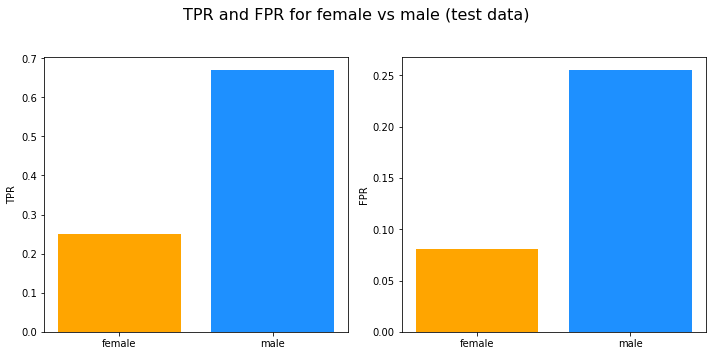

In [39]:
# Run the binary classification pipeline on the original processed data and evaluation on training data
female_tup, male_tup = adult_binary_classification_pipeline(X_train, y_train, X_test, y_test, evaluate="test")

# Calculate and visualize TPR and FPR on the training data for female and male
TPR_f_non_priv, TPR_m_non_priv, FPR_f_non_priv, FPR_m_non_priv = adult_fairness_summary(female_tup, male_tup, show_plots=True, evaluate="test")

In [40]:
# Calculate the difference in TPR (Equalized Opportunity distance)
TPR_diff_non_priv = TPR_m_non_priv-TPR_f_non_priv

# Calculate the difference in FPR (second Equalized Odds distance)
FPR_diff_non_priv = FPR_m_non_priv-FPR_f_non_priv

# Demographic parity (FP + TP rate difference)
dem_parity_non_priv = (FPR_m_non_priv+TPR_m_non_priv)-(FPR_f_non_priv+TPR_f_non_priv)

# Calculate overall accuracy for female and male
ACC_f_non_priv = (female_tup[0] + female_tup[2]) / sum(female_tup)
ACC_m_non_priv = (male_tup[0] + male_tup[2]) / sum(male_tup)

print("TRAINING DATA METRICS:")
print(f"The difference in TPR (equalized opportunity) is: {TPR_diff_non_priv:.4f}")
print(f"The difference in FPR (equalized odds) is: {FPR_diff_non_priv:.4f}")
print(f"The difference in FP + TP rate (Demographic Parity) is: {dem_parity_non_priv:.4f}")
print(f"The overall accuracy for female is: {ACC_f_non_priv:.4f}")
print(f"The overall accuracy for male is: {ACC_m_non_priv:.4f}")

TRAINING DATA METRICS:
The difference in TPR (equalized opportunity) is: 0.4190
The difference in FPR (equalized odds) is: 0.1746
The difference in FP + TP rate (Demographic Parity) is: 0.5936
The overall accuracy for female is: 0.7154
The overall accuracy for male is: 0.7127


## 4.2 MWEM

### 4.2.1 Data preparation

Based on multiplicative weight update mechanism; requires binning of continuous data.

In [41]:
# Recombine X_train and y_train for synthesis
adult_train = pd.concat([X_train, y_train], axis=1)
adult_train

,race,sex,hours_week,occupation,marital,education,workclass,age,relationship,label
232036,0,1,50.0,7,1,2,0,47.0,4,1
494096,0,1,48.0,12,0,6,0,50.0,0,1
323240,0,0,40.0,7,0,5,3,67.0,2,1
1447376,0,0,40.0,20,0,8,0,54.0,0,0
1962,0,1,45.0,11,2,6,7,57.0,0,1
...,...,...,...,...,...,...,...,...,...,...
197595,0,1,40.0,20,0,1,0,32.0,0,0
468779,1,0,40.0,11,2,0,3,30.0,0,0
670908,0,1,50.0,11,0,0,0,50.0,0,1
1277931,0,0,45.0,2,2,0,0,34.0,1,0


In [42]:
# Recombine X_test and y_test for synthesis
adult_test = pd.concat([X_test, y_test], axis=1)

### 4.2.2 Varying $\varepsilon$

In [43]:
def get_synthesizer(synthesizer, epsilon):

    # Instantiate an MWEM synthesizer
    if synthesizer == "MWEM":
        synth = MWEMSynthesizer(epsilon=epsilon, q_count=500, iterations=30, mult_weights_iterations=15, 
        splits=[], split_factor=2, max_bin_count=400)

    return synth

In [44]:
def get_quail_synthesizer(synthesizer, classifier, epsilon, eps_split, target):

    # Instantiate an MWEM synthesizer
    if synthesizer == "MWEM":
        def QuailSynth(epsilon):
            return MWEMSynthesizer(epsilon=epsilon, q_count=500, iterations=30, mult_weights_iterations=15, 
                                    splits=[], split_factor=2, max_bin_count=400)
    
    # Instantiate a DPLR classifier
    if classifier == "DPLR":
        def QuailClassifier(epsilon):
            return DPLR(epsilon=epsilon)

    # Create a QUAIL synthesizer with base synthesizer and DP classifier
    quail = QUAILSynthesizer(epsilon, QuailSynth, QuailClassifier, target, eps_split)

    return quail

In [45]:
# Create function for comparing synthetic data to original and producing visualizations

def compare_synth_to_orig_adult(orig_data, synth_data):

    '''
    Takes in: Processed adult dataset original and synthetic

    Returns: Hypothesis test results for difference in proportions between outcome (label) for groups

    '''
    # We want 4 mus and 4 ps:
    # 1) Orig data vs. synth data share protected group
    # 2) Synth data: % success male vs. female
    # 3) Synth data vs. Orig data: % success male
    # 4) Synth data vs. orig data: % success female

    # Test 1: Percent female - original vs. synthetic

    # Assign samples
    n_orig = orig_data.shape[0]
    n_synth = synth_data.shape[0]

    sample_f_orig = (orig_data.groupby('sex').size())[0]
    sample_f_synth = (synth_data.groupby('sex').size())[0]

    print(orig_data.groupby('sex').size())
    print(sample_f_orig/n_orig)
    print(synth_data.groupby('sex').size())
    print(sample_f_synth/n_synth)

    successes_pct_female = np.array([sample_f_orig, sample_f_synth])
    samples_pct_female = np.array([n_orig, n_synth])
    orig_synth_dif_pct_female = (sample_f_orig/n_orig) - (sample_f_synth/n_synth)

    # Set significance level
    significance = 0.05

    # Perform 2-sided test
    stat_pct_female, p_value_pct_female = proportions_ztest(count=successes_pct_female, nobs=samples_pct_female,  alternative='two-sided')


    # Test 2: Synth data: % success male vs. female

    # Contingency & Ns for orig
    contingency_table_orig = pd.crosstab(orig_data.label, orig_data.sex).apply(lambda r:r/r.sum(),axis=0)
    contingency_table_n_orig = pd.crosstab(orig_data.label, orig_data.sex)
    gender_ns_orig = orig_data.groupby('sex').size()

    # Contingency & Ns for synth
    contingency_table_synth = pd.crosstab(synth_data.label, synth_data.sex).apply(lambda r:r/r.sum(),axis=0)
    contingency_table_n_synth = pd.crosstab(synth_data.label, synth_data.sex)
    gender_ns_synth = synth_data.groupby('sex').size()


    # Assign variables for orig data
    p_female_orig = contingency_table_orig[0][1]
    p_male_orig = contingency_table_orig[1][1]
    success_female_orig = contingency_table_n_orig[0][1]
    success_male_orig = contingency_table_n_orig[1][1]
    n_female_orig = gender_ns_orig[0]
    n_male_orig = gender_ns_orig[1]

    # Assign variables for synth data
    p_female_synth = contingency_table_synth[0][1]
    p_male_synth = contingency_table_synth[1][1]
    success_female_synth = contingency_table_n_synth[0][1]
    success_male_synth = contingency_table_n_synth[1][1]
    n_female_synth = gender_ns_synth[0]
    n_male_synth = gender_ns_synth[1]

    successes_synth = np.array([success_female_synth, success_male_synth])
    samples_synth = np.array([n_female_synth, n_male_synth])

    # Perform test
    mu_synth_men_vs_women = p_male_synth-p_female_synth
    stat_synth_men_vs_women, p_value_synth_men_vs_women = proportions_ztest(count=successes_synth, nobs=samples_synth,  alternative='two-sided')


    # Test 3: Synth data vs. Orig data: % success male

    successes_male_synth_v_orig = np.array([success_male_orig, success_male_synth])
    samples_male_synth_v_orig = np.array([n_male_orig, n_male_synth])

    # Perform test
    mu_male_synth_v_orig = p_male_orig-p_male_synth
    stat_male_synth_v_orig, p_value_male_synth_v_orig = proportions_ztest(count=successes_male_synth_v_orig, nobs=samples_male_synth_v_orig,  alternative='two-sided')


    # Test 4: Synth data vs. Orig data: % success female

    successes_female_synth_v_orig = np.array([success_female_orig, success_female_synth])
    samples_female_synth_v_orig = np.array([n_female_orig, n_female_synth])

    # Perform test
    mu_female_synth_v_orig = p_female_orig-p_female_synth
    stat_female_synth_v_orig, p_value_female_synth_v_orig = proportions_ztest(count=successes_female_synth_v_orig, nobs=samples_female_synth_v_orig,  alternative='two-sided')

    # #
    # Save and return values
    mus_per_type = np.zeros((8,))
    p_vals_per_type = np.zeros((4,))

    synth_men_vs_women = 0
    synth_vs_orig_percent_women = 1
    female_success_synth_vs_orig = 2
    male_success_synth_vs_orig = 3
    pct_female_orig = 4
    pct_female_synth = 5

    # Fill in p vals
    p_vals_per_type[synth_men_vs_women] = p_value_synth_men_vs_women
    p_vals_per_type[synth_vs_orig_percent_women] = p_value_pct_female
    p_vals_per_type[female_success_synth_vs_orig] = p_value_female_synth_v_orig
    p_vals_per_type[male_success_synth_vs_orig] = p_value_male_synth_v_orig

    synth_pct_success_male = 0
    synth_pct_success_female = 1
    pct_female_orig = 2
    pct_female_synth = 3
    success_rate_female_synth = 4
    success_rate_female_orig = 5
    success_rate_male_synth = 6
    success_rate_male_orig = 7

    # Fill in summary statistics for plotting
    mus_per_type[synth_pct_success_male] = p_male_synth
    mus_per_type[synth_pct_success_female] = p_female_synth
    mus_per_type[pct_female_orig] = sample_f_orig/n_orig
    mus_per_type[pct_female_synth] = sample_f_synth/n_synth
    mus_per_type[success_rate_female_synth] = p_female_synth
    mus_per_type[success_rate_female_orig] = p_female_orig 
    mus_per_type[success_rate_male_synth] = p_male_synth
    mus_per_type[success_rate_male_orig] = p_male_orig

    return mus_per_type, p_vals_per_type

In [46]:
def adult_fairness_calculate_comparisons(epsilon_vals, adult_train, adult_test, synthesizer="MWEM", 
                                    quail=False, classifier=None, eps_split=None, n_reps=1):
    '''
    Evaluates differencs between non-private data 
    and synthetic data using hypothesis testing,
    and gather metrics for plotting.
    
    INPUTS
    ======
    epsilon_vals: list containing privacy loss
    parameter values to apply, array-like
    adult_train: non-private training data (X and 
    y) to train synthesizer, pandas DataFrame
    adult_test: non-private test data (X and y)
    synthesizer: the type of synthesizer to use, str
    n_reps: the number of synthetic data sets to
    generate for each epsilon, int
    
    RETURNS
    =======
    Numpy arrays with comparative metrics for plotting.
    '''
    
    # Initializ output
    mus = np.zeros((len(epsilon_vals),n_reps, 8))
    p_vals = np.zeros((len(epsilon_vals),n_reps, 4))
    
    # Loop through epsilon values
    for epsilon_idx, epsilon in enumerate(epsilon_vals):

        # Loop through number of reps
        for n_idx in range(n_reps):

            if quail:  
                # Create a QUAIL-wrapped synthesizer
                quail = get_quail_synthesizer(synthesizer, classifier, epsilon, eps_split, target="label")

                # Fit synthesizer to the training data
                quail.fit(adult_train)

                # Create private synthetic data
                adult_train_synth = quail.sample(int(adult_train.shape[0]))

            else:
                # Create a regular synthesizer
                synth = get_synthesizer(synthesizer, epsilon)
        
                # Fit synthesizer to the training data
                synth.fit(adult_train.to_numpy())
                
                # Create private synthetic data
                adult_train_synth = pd.DataFrame(synth.sample(int(adult_train.shape[0])), columns=adult_train.columns)
            
            # Split synthetic training data into X and y
            X_train, y_train = adult_train_synth.drop(["label"], axis=1), adult_train_synth["label"]
            
            # Split the non-private test data into X and y
            X_test, y_test = adult_test.drop(["label"], axis=1), adult_test["label"]

            # compute the mu and the p for this test set
            curr_mus, curr_p_values = compare_synth_to_orig_adult(adult_train, adult_train_synth)
            mus[epsilon_idx][n_idx] = curr_mus
            p_vals[epsilon_idx][n_idx] = curr_p_values
        
    return mus, p_vals

In [47]:
try:
    # Try to load the output with ten repetitions
    acs_income_mwem_comparison_mus_1 = np.load("acs_income_mwem_comparison_mus_1.npy", allow_pickle=True)
    acs_income_mwem_comparison_p_vals_1 = np.load("acs_income_mwem_comparison_p_vals_1.npy", allow_pickle=True)
    epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
    
except:
    # Set range of epsilon values
    epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

    # Get dictionary of fairness metrics with 1 repetition for range of values
    acs_income_mwem_comparison_mus_1, acs_income_mwem_comparison_p_vals_1 = adult_fairness_calculate_comparisons(epsilon_vals, adult_train, adult_test, synthesizer="MWEM", n_reps=10)
    
    # Save output
    np.save("acs_income_mwem_comparison_mus_1.npy", acs_income_mwem_comparison_mus_1)
    np.save("acs_income_mwem_comparison_p_vals_1.npy", acs_income_mwem_comparison_p_vals_1)

#### Plot comparisons of synthetic to non-private data

In [48]:
# Create helper function to plot mus and epsilons
def plot_mus_p_vals(mus, p_vals, epsilon_vals, title):

    # For each epsilon value, calculate mean of the 4 mus and p-vals
    # average mu
    avg_mus = mus.mean(axis=1)

    # percent of p-vals < 0.05
    p_vals_signif = np.where(p_vals < 0.05, 1, 0)
    pct_signif = p_vals_signif.mean(axis=1)

    # Initialize figure
    fig, axs = plt.subplots(2, 4, figsize=(30,10))

    # Plot
    min_eps = np.min(epsilon_vals)
    max_eps = np.max(epsilon_vals)
    axs[0][0].plot(epsilon_vals, avg_mus[:,0], c="darkorange", marker='o', label = 'Male')
    axs[0][0].plot(epsilon_vals, avg_mus[:,1], c="royalblue", marker='o', label = 'Female')
    axs[0][0].set_xlabel("Privacy loss (epsilon)")
    axs[0][0].set_ylabel("Difference: % >50K, Male vs. Female")
    axs[0][0].set_title("Dif: % >50K, Male vs. Female (Synthetic)")
    axs[0][0].legend()

    axs[0][1].plot(epsilon_vals, avg_mus[:,2], c="darkorange", marker='o', label = 'Original')
    axs[0][1].plot(epsilon_vals, avg_mus[:,3], c="royalblue", marker='o', label = 'Synthetic')
    axs[0][1].set_xlabel("Privacy loss (epsilon)")
    axs[0][1].set_ylabel("Difference in % Female")
    axs[0][1].set_title("Dif in % Female: Synth v. Original Data")
    axs[0][1].legend()

    axs[0][2].plot(epsilon_vals, avg_mus[:,4], c="royalblue", marker='o', label = 'Synthetic')
    axs[0][2].plot(epsilon_vals, avg_mus[:,5], c="darkorange", marker='o', label = 'Original')
    axs[0][2].set_xlabel("Privacy loss (epsilon)")
    axs[0][2].set_ylabel("% Difference")
    axs[0][2].set_title("Dif in % >50K: Synth v. Orig Data (Female)")
    axs[0][2].legend()

    axs[0][3].plot(epsilon_vals, avg_mus[:,6], c="royalblue", marker='o', label = 'Synthetic')
    axs[0][3].plot(epsilon_vals, avg_mus[:,7], c="darkorange", marker='o', label = 'Original')
    axs[0][3].set_xlabel("Privacy loss (epsilon)")
    axs[0][3].set_ylabel("% Difference")
    axs[0][3].set_title("Dif in % >50K: Synth vs. Orig Data (Male)")
    axs[0][3].legend()

    ##
    ##

    axs[1][0].plot(epsilon_vals, pct_signif[:,0], c="red", marker='o')
    axs[1][0].set_xlabel("Privacy loss (epsilon)")
    axs[1][0].set_ylabel("% Signif Difference")
    axs[1][0].set_title("% Signif Dif: >50K, Male vs. Female (Synth)")

    axs[1][1].plot(epsilon_vals, pct_signif[:,1], c="red", marker='o')
    axs[1][1].set_xlabel("Privacy loss (epsilon)")
    axs[1][1].set_ylabel("% Signif Difference")
    axs[1][1].set_title("Signif Dif in % Female: Synth vs. Orig Data")

    axs[1][2].plot(epsilon_vals, pct_signif[:,2], c="red", marker='o')
    axs[1][2].set_xlabel("Privacy loss (epsilon)")
    axs[1][2].set_ylabel("% Signif Difference")
    axs[1][2].set_title("Signif Dif in % >50K: Synth vs. Orig Data (Female)")

    axs[1][3].plot(epsilon_vals, pct_signif[:,3], c="red", marker='o')
    axs[1][3].set_xlabel("Privacy loss (epsilon)")
    axs[1][3].set_ylabel("% Signif Difference")
    axs[1][3].set_title("Signif Dif in % >50K: Synth vs. Orig Data (Male)")

    plt.suptitle(title)

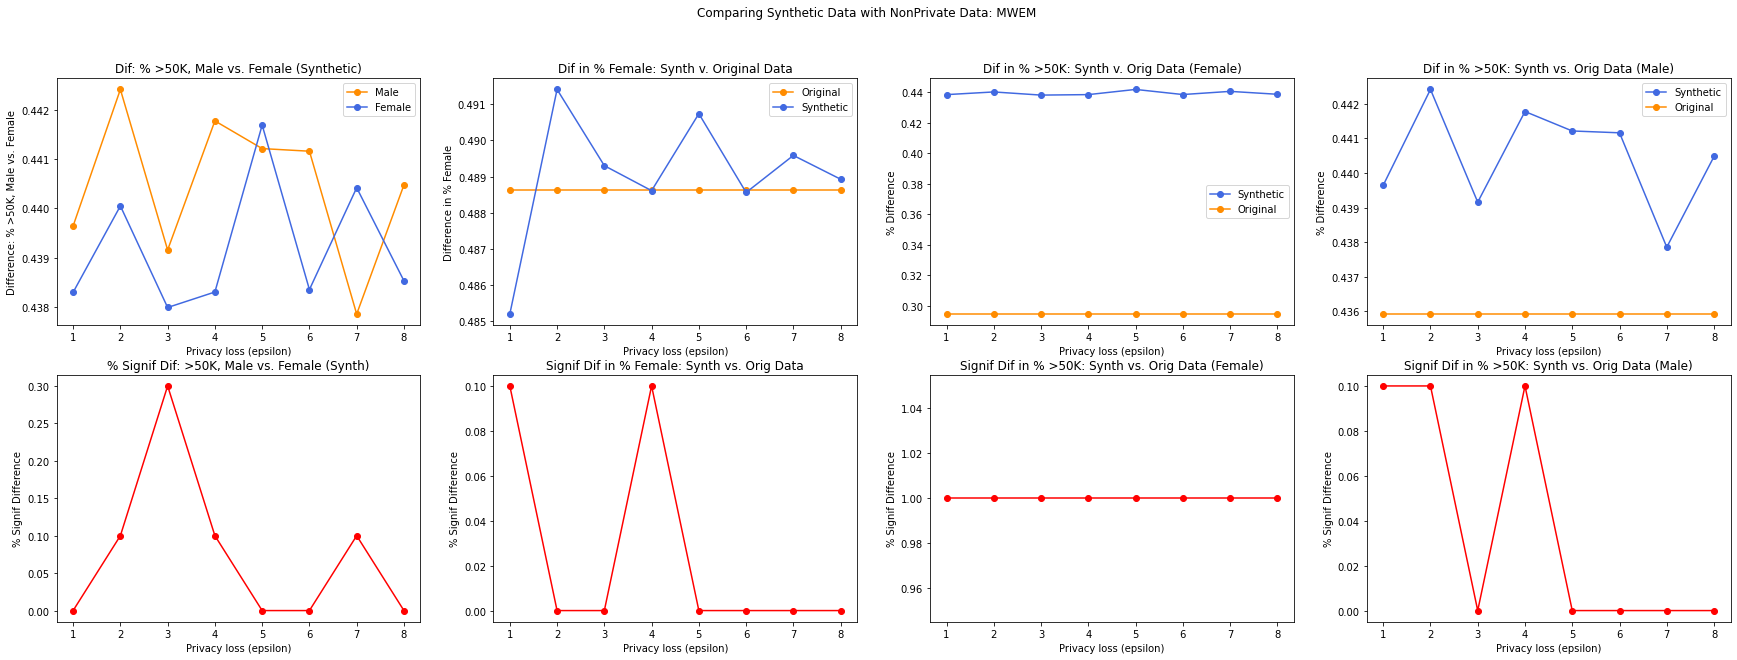

In [49]:
# Plot data comparisons
plot_mus_p_vals(acs_income_mwem_comparison_mus_1, acs_income_mwem_comparison_p_vals_1, epsilon_vals, title = "Comparing Synthetic Data with NonPrivate Data: MWEM")

## 4.3 QUAIL-MWEM

In [50]:

try:
    # Try to load the dictionary with 15 repetitions
    adult_quail_comparison_mus_1 = np.load("adult_quail_comparison_mus_1.npy", allow_pickle=True)
    adult_quail_comparison_p_vals_1 = np.load("adult_quail_comparison_p_vals_1.npy", allow_pickle=True)
    
    epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]
    
except:
    # Set range of epsilon values
    epsilon_vals = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0]

    # Get dictionary of averaged fairness metrics across 10 repetitions for range of values
    adult_quail_comparison_mus_1, adult_quail_comparison_p_vals_1 = adult_fairness_calculate_comparisons(epsilon_vals, adult_train, adult_test, synthesizer="MWEM", quail=True, classifier="DPLR", eps_split=0.8, n_reps=15)
    
    # Save output
    np.save("adult_quail_comparison_mus_1.npy", adult_quail_comparison_mus_1)
    np.save("adult_quail_comparison_p_vals_1.npy", adult_quail_comparison_p_vals_1)


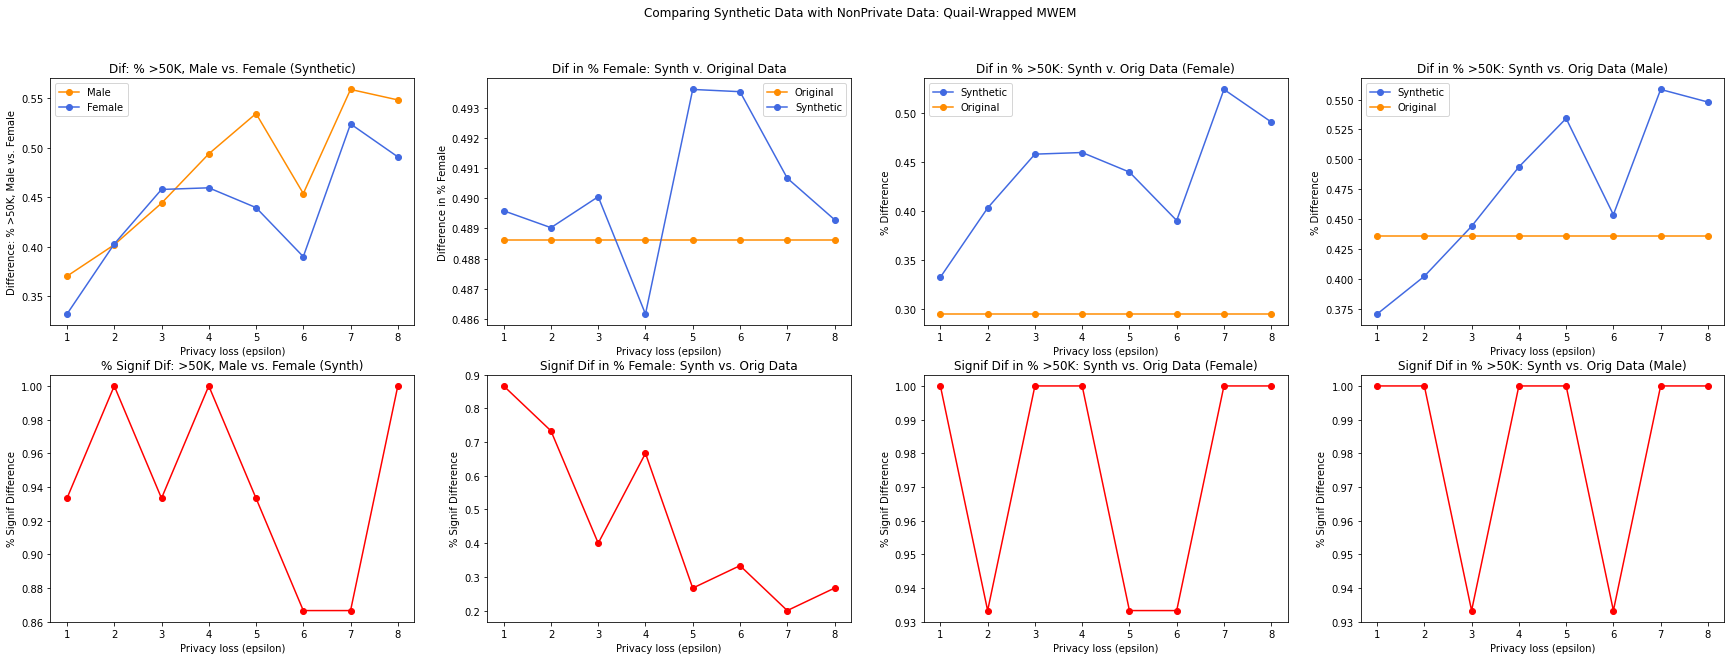

In [51]:
# Plot data comparisons
plot_mus_p_vals(adult_quail_comparison_mus_1, adult_quail_comparison_p_vals_1, epsilon_vals, title = "Comparing Synthetic Data with NonPrivate Data: Quail-Wrapped MWEM")

## 4.4 DPCTGAN

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=aa928c63-0856-4021-a156-02d09e35182a' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>